Tutorial Look Up Table
==================

This example is based on the xarray library for an efficient I/O of the Look Up Table (LUT)
First, we import some basic python modules and we create the dimensions of out LUT.
In this case I am setting up some frequencies, and sizes.
I will use only one temperature, but it is possible to put more, just by adding more values ot the array.
The scat_angle dimension is required if we want to save the phase function in the LUT.

We fix the particle properties. It is possible in general, to have the particle properties as a dimension.

In [4]:
import os
import socket
from datetime import datetime
import numpy as np
import xarray as xr
import snowScatt
import matplotlib.pyplot as plt

## Input parameters

Dmax = np.linspace(0.1e-3, 20.0e-3, 1000) # list of sizes
sizes = xr.IndexVariable(dims='size', data=Dmax,
                         attrs={'long_name':'Size - Maximum dimension',
                                'units':'meters'})
particle = 'Leinonen15tabA00'
filename = 'leinonen_A00_LUT.nc' # output filename

frequency =  np.array([5.6e9, 9.6e9, 13.6e9, 35.6e9, 94.0e9]) # frequencies
frequency = xr.IndexVariable(dims='frequency', data=frequency,
                             attrs={'units':'Hertz'})
temperature = xr.IndexVariable(dims='temperature', data=[270.0], # temperatures
                               attrs={'units':'Kelvin'})
Nangles = 721  # number of angles of the phase function subdivision
angles = xr.IndexVariable(dims='scat_angle',
                          data=np.linspace(0, np.pi, Nangles),
                          attrs={'long_name':'scattering angle',
                                 'units':'radians'})

We create the empty variable arrays. Each one is defined by its own set of dimensions

In [5]:
## Create empty xarray variables
dims = ['size', 'frequency', 'temperature']
coords = {'size': sizes,
          'frequency': frequency,
          'temperature': temperature}

Cext = xr.DataArray(dims=dims, coords=coords,
                    attrs={'long_name':'Extinction cross-section',
                           'units':'meters**2'})
Cabs = xr.DataArray(dims=dims, coords=coords,
                    attrs={'long_name':'Absorption cross-section',
                           'units':'meters**2'})
Csca = xr.DataArray(dims=dims, coords=coords,
                    attrs={'long_name':'Scattering cross-section',
                           'units':'meters**2'})
Cbck = xr.DataArray(dims=dims, coords=coords,
                    attrs={'long_name':'Radar backscattering cross section',
                           'units':'meters**2'})
asym = xr.DataArray(dims=dims, coords=coords,
                    attrs={'long_name':'Asymmetry parameter',
                           'units':'dimensionless'})
dims = ['size', 'scat_angle', 'frequency', 'temperature']
angles = np.linspace(0.0, np.pi, Nangles)
coords['scat_angle'] = angles
phase = xr.DataArray(dims=dims, coords=coords,
                     attrs={'long_name':'Phase function',
                            'units':'dimensionless???'})
mass = xr.DataArray(dims=['size'],
                    coords={'size':sizes},
                    attrs={'long_name':'mass',
                           'units':'kilograms'})
vel = xr.DataArray(np.empty_like(sizes), dims=['size'], coords={'size':sizes},
                   attrs={'long_name':'Terminal fallspeed according to Boehm',
                          'units':'meters/second'})
area = xr.DataArray(np.empty_like(sizes), dims=['size'], coords={'size':sizes},
                    attrs={'long_name':'Projected area',
                           'units':'meters**2'})


We finally start the computation and fill the empty arrays.
While we compute we also plot some basic variable to have a quick look at what we are computing

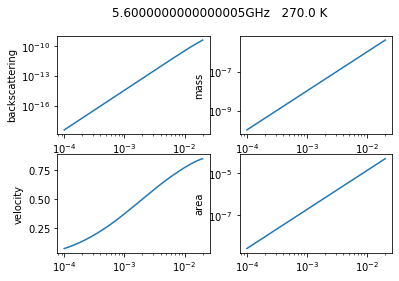

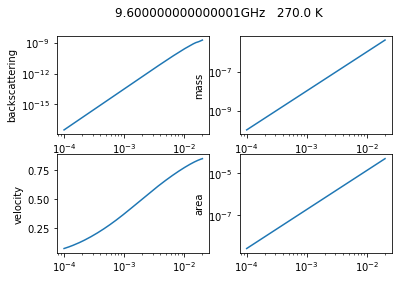

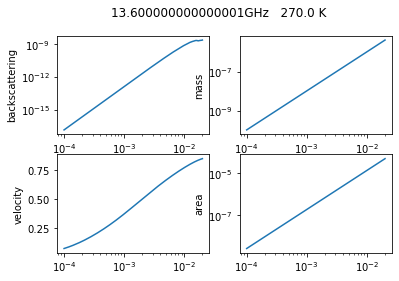

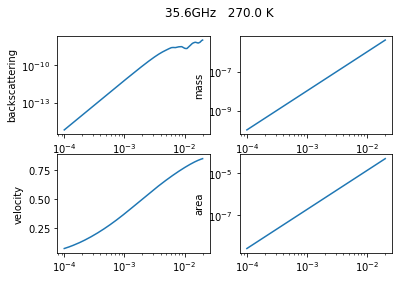

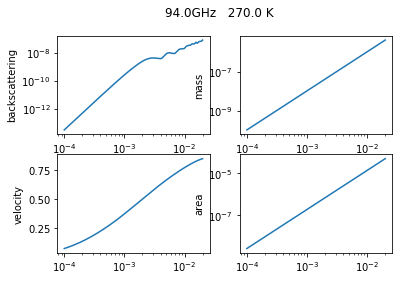

In [6]:
## Compute
for fi, freq in enumerate(frequency):
    wl = snowScatt._compute._c/freq.values
    for ti, temp in enumerate(temperature):
        SS_RGA = snowScatt.calcProperties(diameters=Dmax,
                                          wavelength=wl,
                                          properties=particle,
                                          temperature=temp.values,
                                          Nangles=Nangles)
        ssCext, ssCabs, ssCsca, ssCbck, ssasym, ssphase, mass_p, ssvel, ssarea = SS_RGA
        Cext.loc[sizes, freq, temp] = ssCext
        Cabs.loc[sizes, freq, temp] = ssCabs
        Csca.loc[sizes, freq, temp] = ssCsca
        Cbck.loc[sizes, freq, temp] = ssCbck
        asym.loc[sizes, freq, temp] = ssasym
        phase.loc[sizes, angles, freq, temp] = ssphase
        f, axs = plt.subplots(2, 2)
        axs[0, 0].loglog(Dmax, ssCbck)
        axs[0, 0].set_ylabel('backscattering')
        axs[0, 1].loglog(Dmax, mass_p)
        axs[0, 1].set_ylabel('mass')
        axs[1, 0].semilogx(Dmax, ssvel)
        axs[1, 0].set_ylabel('velocity')
        axs[1, 1].loglog(Dmax, ssarea)
        axs[1, 1].set_ylabel('area')
        f.suptitle(str(freq.values*1.0e-9)+'GHz   '+str(temp.values)+' K')
        f.savefig(str(freq.values*1.0e-9)+'_'+str(temp.values)+'.png')
        

# These last two depend only on size, no need to recompute
mass.loc[sizes] = mass_p
vel.loc[sizes] = ssvel
area.loc[sizes] = ssarea

We finalize the computation by putting together the variables into one dataset and saving it as a netCDF file. We add some basic and autometic general attributes such as the username, the host machine name, and the date of creation.

In [7]:
## Finalize dataset and write netCDF file
variables = {'Cext':Cext,
             'Cabs':Cabs,
             'Csca':Csca,
             'Cbck':Cbck,
             'asym':asym,
             'phase':phase,
             'mass':mass,
             'vel':vel,
             'area':area}

global_attributes = {'created_by':os.environ['USER'],
                     'host_machine':socket.gethostname(),
                     'particle_properties':particle,
                     'created_on':str(datetime.now()),
                     'comment':'this is just a test'}

dataset = xr.Dataset(data_vars=variables,
                     coords=coords,
                     attrs=global_attributes)

dataset.to_netcdf(filename)

AttributeError: 'Dataset' object has no attribute 'to_csv'

Since this is a multi-dimensional LUT it is most conveniently stored as netCDF, but we also show how to save a bunch of ASCII csv files to make the example more complete.

In [10]:
dataset.dims

Frozen(SortedKeysDict({'size': 1000, 'frequency': 5, 'temperature': 1, 'scat_angle': 721}))

In [19]:
table=dataset.Cbck.squeeze('temperature').to_pandas()
table.to_csv('backscattering_table.csv')
table

frequency,5.600000e+09,9.600000e+09,1.360000e+10,3.560000e+10,9.400000e+10
size,,,,,
0.00010,3.838219e-19,3.314802e-18,1.335121e-17,6.267222e-16,3.041995e-14
0.00012,7.928839e-19,6.847549e-18,2.758003e-17,1.294523e-15,6.279367e-14
0.00014,1.464727e-18,1.264969e-17,5.094896e-17,2.391131e-15,1.158997e-13
0.00016,2.493137e-18,2.153109e-17,8.671953e-17,4.069406e-15,1.970754e-13
0.00018,3.986183e-18,3.442498e-17,1.386498e-16,6.505376e-15,3.147358e-13
...,...,...,...,...,...
0.01992,4.177232e-10,1.826404e-09,2.449269e-09,1.074654e-08,7.664113e-08
0.01994,4.192151e-10,1.831346e-09,2.452651e-09,1.077327e-08,7.699276e-08
0.01996,4.207107e-10,1.836295e-09,2.456027e-09,1.079988e-08,7.734349e-08
